<a href="https://colab.research.google.com/github/hyoungsin/project/blob/main/Boltzmann_Machine_ipynb(BIG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boltzmann Machine (RBM)

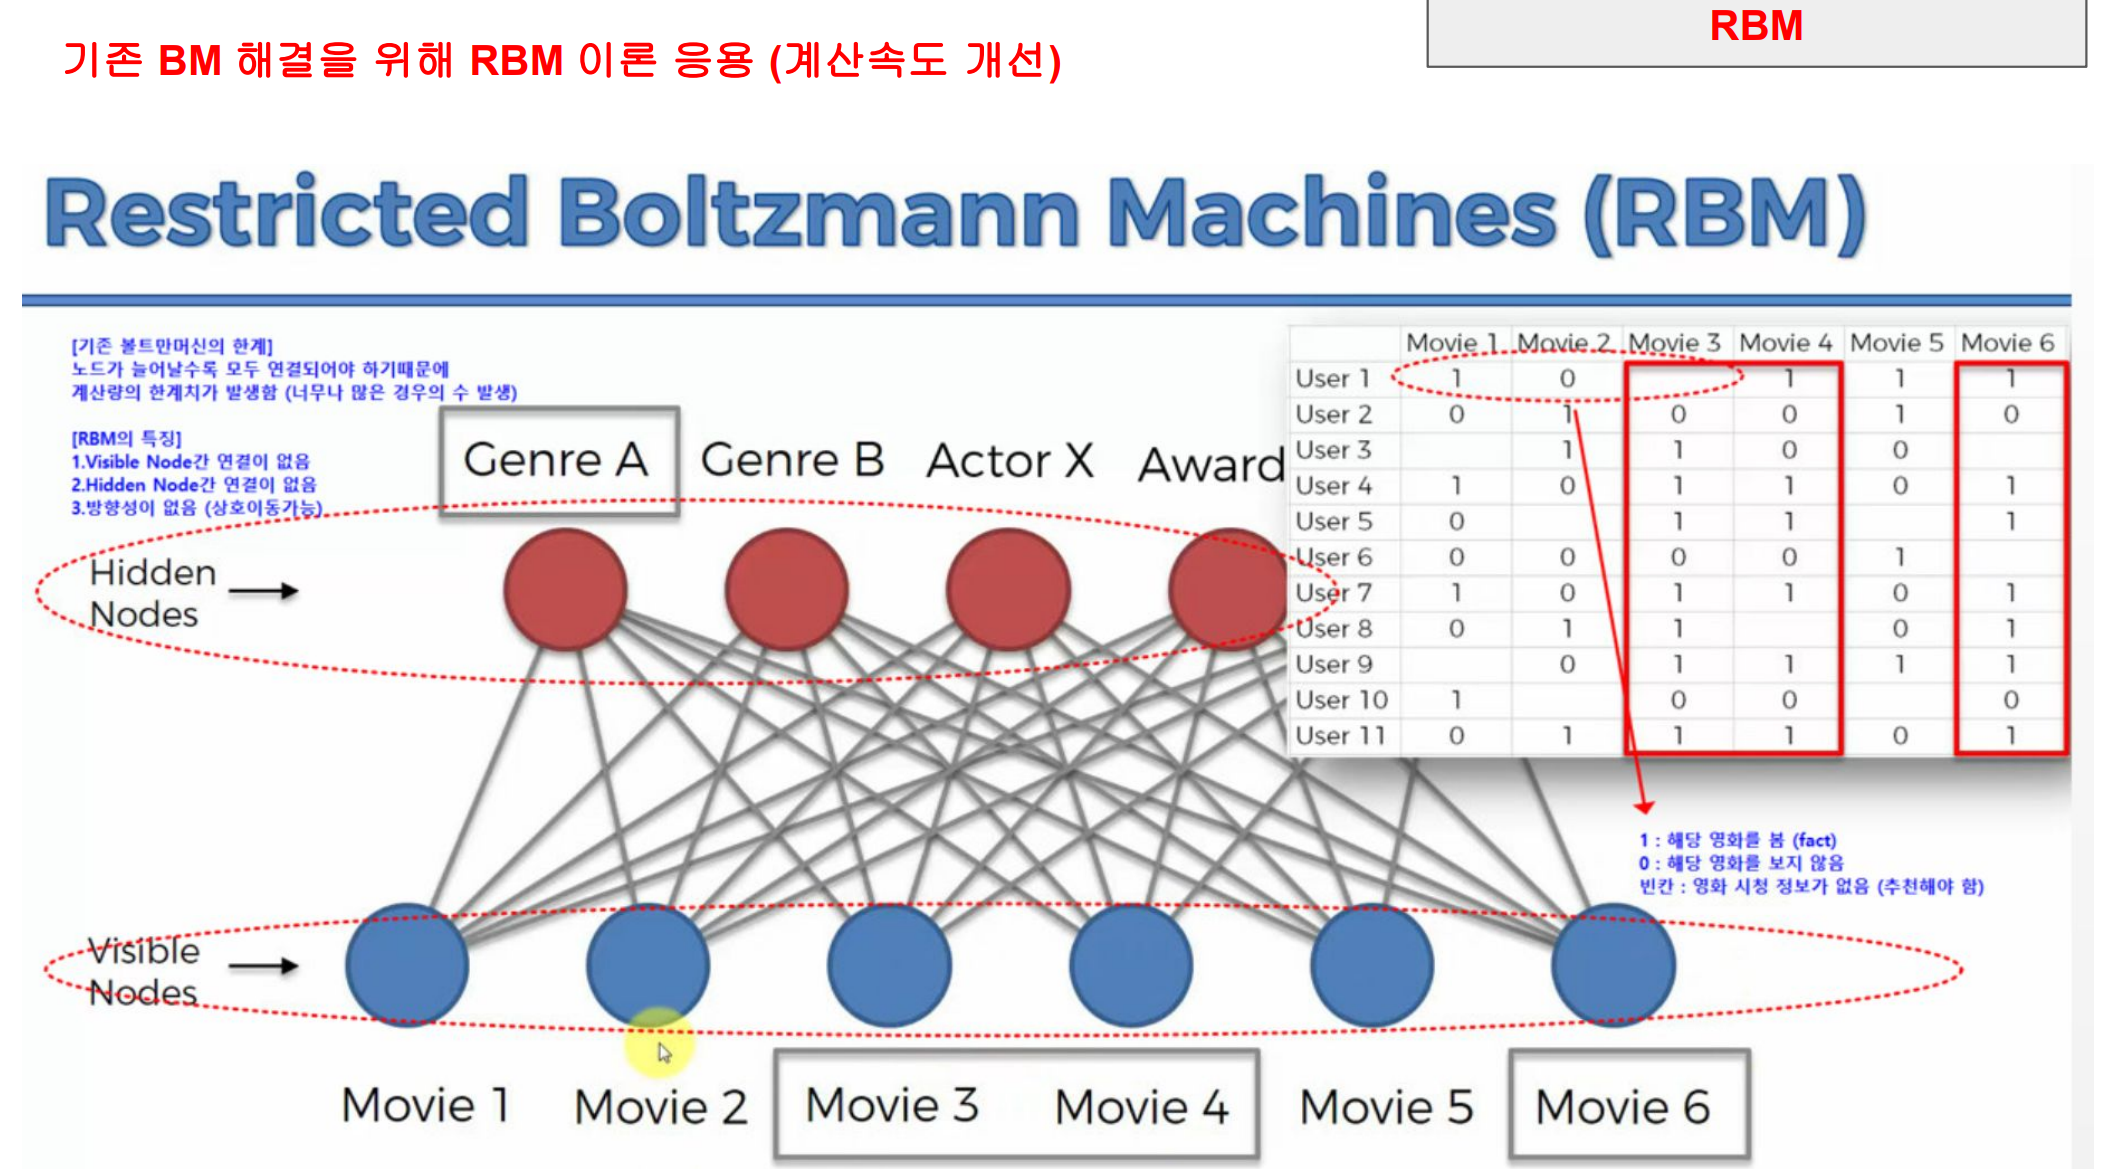

- 볼츠만 머신에서의 "대조 발산"은 Contrastive Divergence 알고리즘에서
근사적인 샘플링과 기댓값 계산을 위해 일정한 수준의 분산을 허용하는 특성을 나타냅니다.("대조"는 "비교"를 의미하며, "발산"은 "분산"이라는 의미)

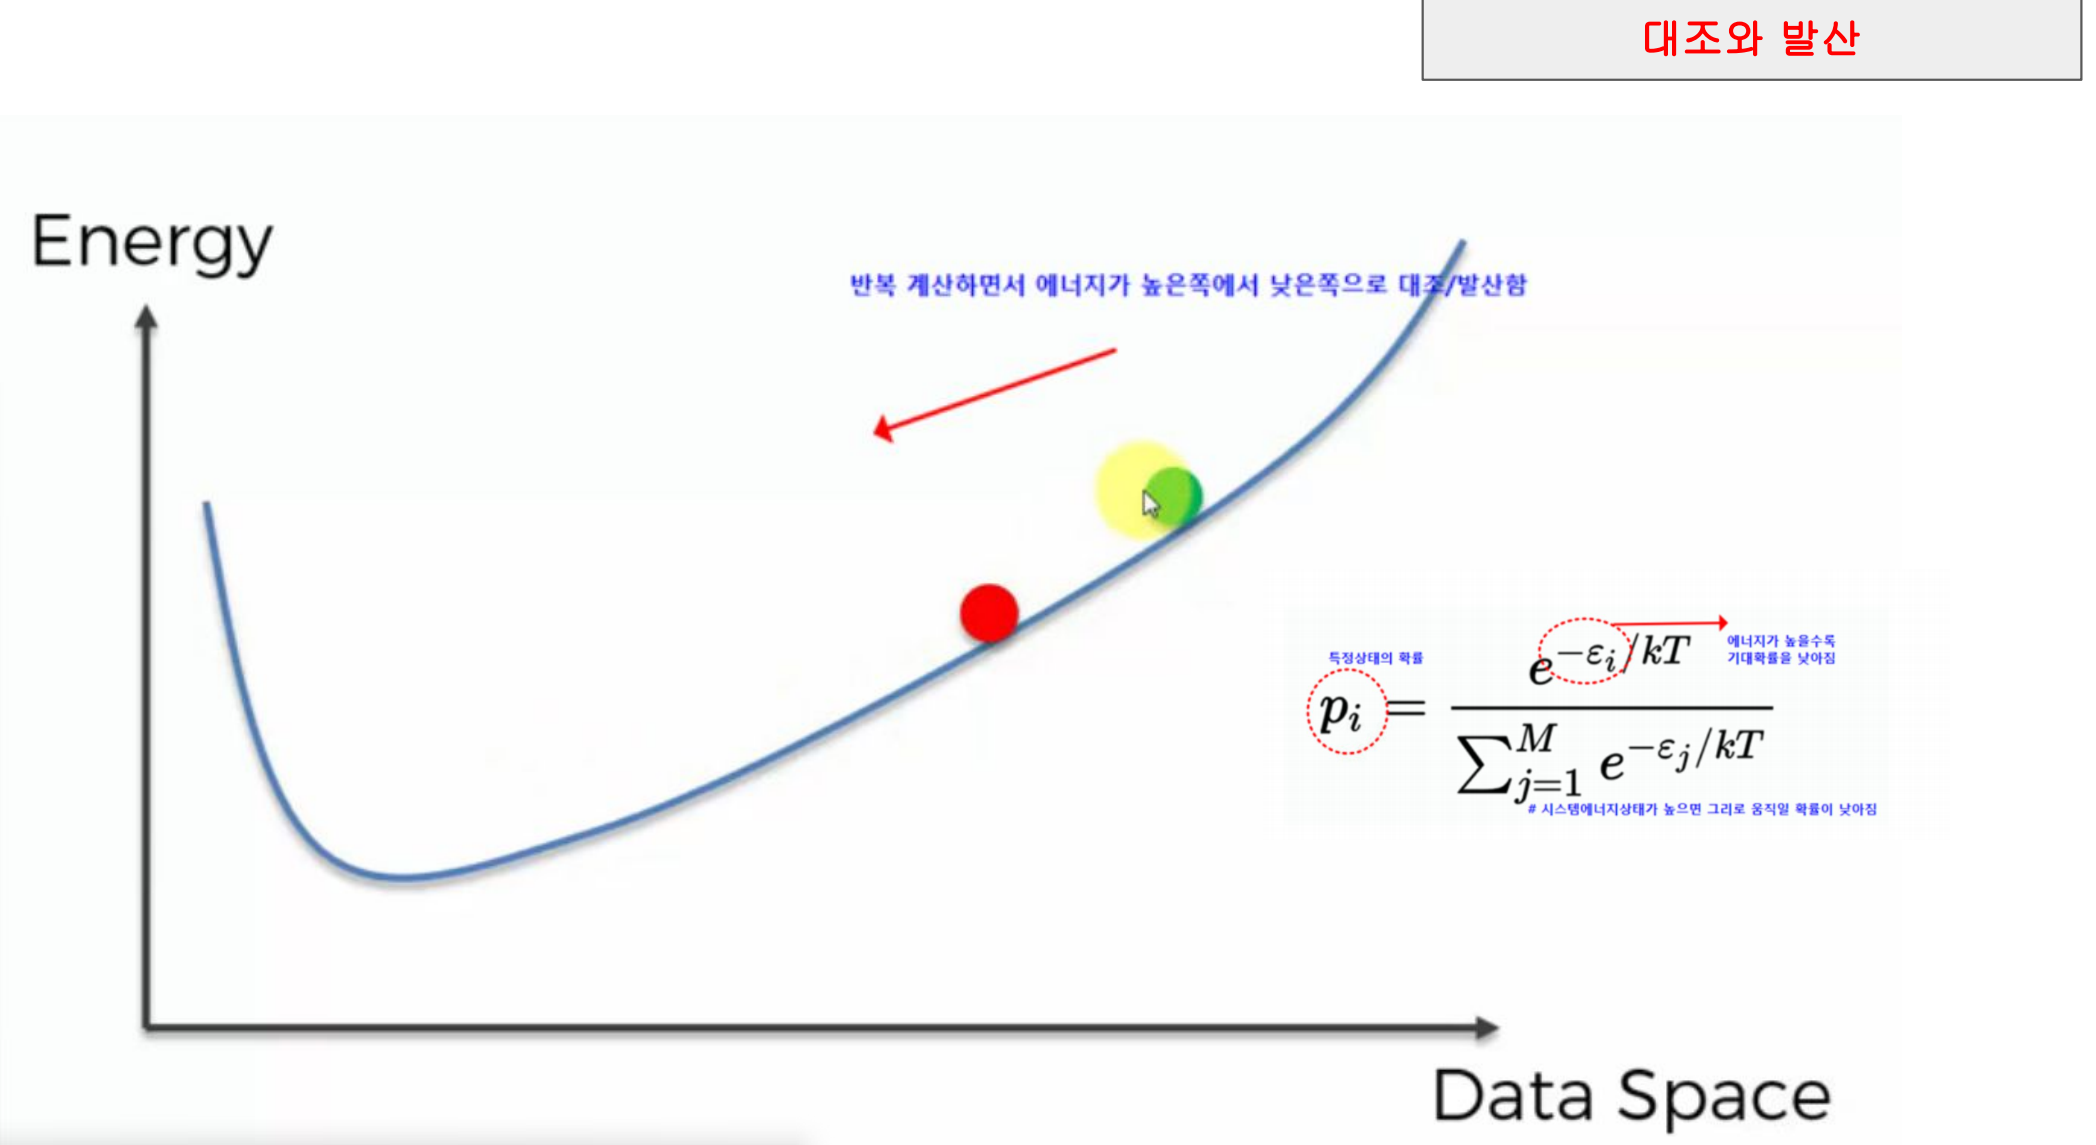

## 1.Data & Library생성

###ML-100K

In [1]:
#web site주소로 데이터불러와서 unzip하고 구글드라이버에저장하기
!wget "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
!unzip ml-100k.zip
!ls

--2023-08-31 12:53:25--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  2.89MB/s    in 1.6s    

2023-08-31 12:53:27 (2.89 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

###ML-1M

In [2]:
!wget "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
!unzip ml-1m.zip
!ls

--2023-08-31 12:53:28--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  3.35MB/s    in 1.7s    

2023-08-31 12:53:30 (3.35 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
ml-100k  ml-100k.zip  ml-1m  ml-1m.zip	sample_data


### Library구성

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

### Dataset구성

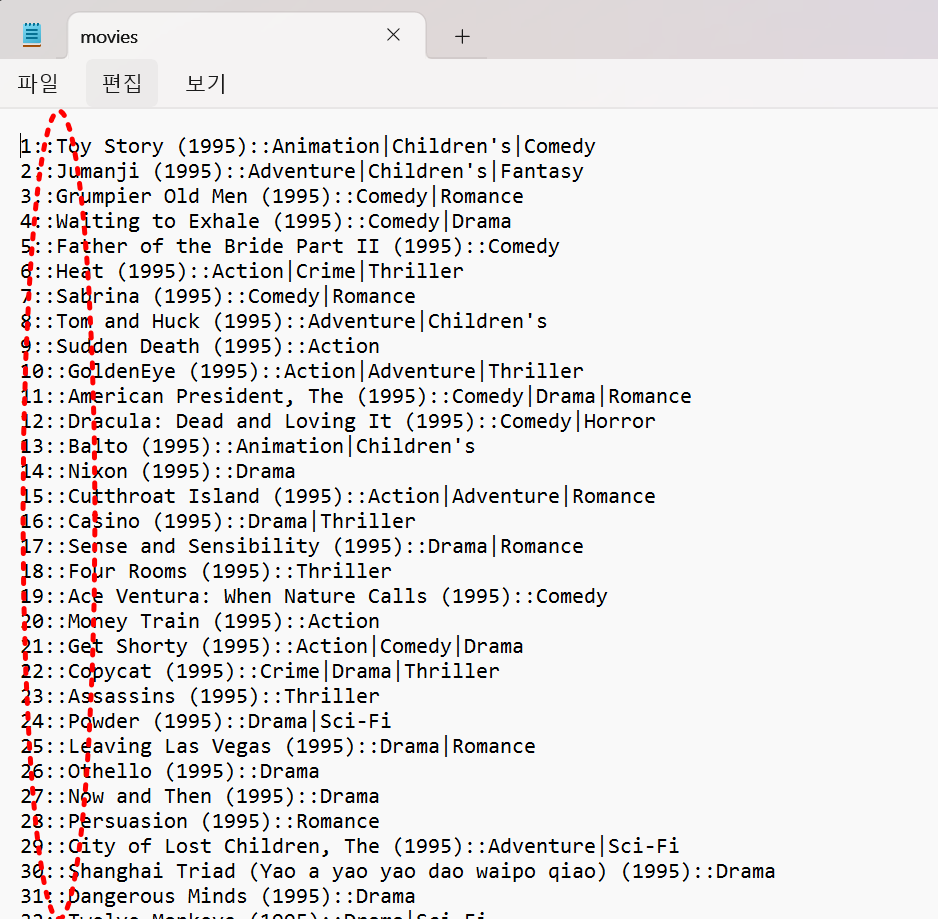

In [4]:
# We won't be using this dataset.
movies = pd.read_csv('ml-1m/movies.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
users = pd.read_csv('ml-1m/users.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
ratings = pd.read_csv('ml-1m/ratings.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')

In [5]:
movies

0                                   1                             2
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
...    ...                                 ...                           ...
3878  3948             Meet the Parents (2000)                        Comedy
3879  3949          Requiem for a Dream (2000)                         Drama
3880  3950                    Tigerland (2000)                         Drama
3881  3951             Two Family House (2000)                         Drama
3882  3952               Contender, The (2000)                Drama|Thriller

[3883 rows x 3 columns]

In [6]:
users

0  1   2   3      4
0        1  F   1  10  48067
1        2  M  56  16  70072
2        3  M  25  15  55117
3        4  M  45   7  02460
4        5  M  25  20  55455
...    ... ..  ..  ..    ...
6035  6036  F  25  15  32603
6036  6037  F  45   1  76006
6037  6038  F  56   1  14706
6038  6039  F  45   0  01060
6039  6040  M  25   6  11106

[6040 rows x 5 columns]

In [7]:
ratings

0     1  2          3
0           1  1193  5  978300760
1           1   661  3  978302109
2           1   914  3  978301968
3           1  3408  4  978300275
4           1  2355  5  978824291
...       ...   ... ..        ...
1000204  6040  1091  1  956716541
1000205  6040  1094  5  956704887
1000206  6040   562  5  956704746
1000207  6040  1096  4  956715648
1000208  6040  1097  4  956715569

[1000209 rows x 4 columns]

### Train/Test Data생성


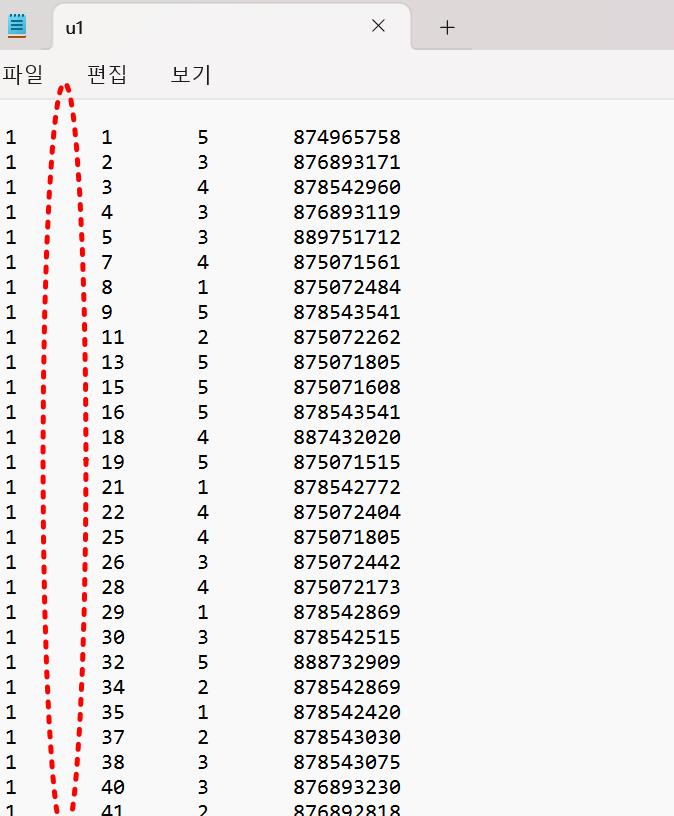

In [8]:
training_set = pd.read_csv('ml-100k/u1.base', delimiter = '\t') #tab으로 구분되어 있음 (default = ',')
training_set = np.array(training_set, dtype = 'int')
test_set = pd.read_csv('ml-100k/u1.test', delimiter = '\t')
test_set = np.array(test_set, dtype = 'int')

In [9]:
print(training_set.shape)
print(type(training_set))

(79999, 4)
<class 'numpy.ndarray'>


## 2.User/Movie수 산출

In [10]:
nb_users = int(max(max(training_set[:, 0], ), max(test_set[:, 0]))) # train datset과 test dataset중 index(user no)가 제일큰 값 찾기 (교차검증시 train/test 합함)
nb_movies = int(max(max(training_set[:, 1], ), max(test_set[:, 1])))

## 3.데이터행렬구성

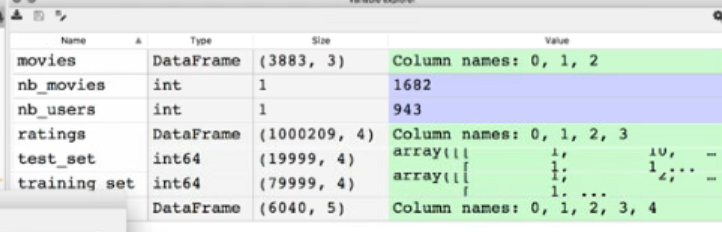

- user id, 영화종id,등급

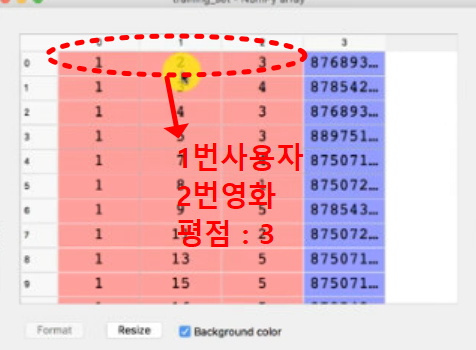

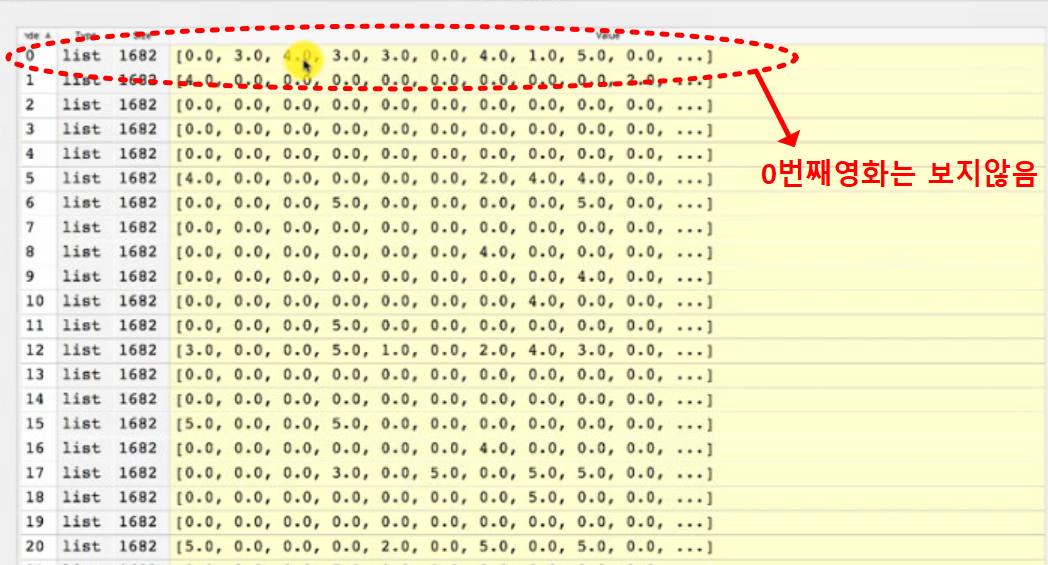

In [11]:
#행렬변환 함수정의
def convert(data):
  new_data = []
  for id_users in range(1, nb_users + 1):
    id_movies = data[:, 1] [data[:, 0] == id_users]
    id_ratings = data[:, 2] [data[:, 0] == id_users]
    ratings = np.zeros(nb_movies)
    ratings[id_movies - 1] = id_ratings
    new_data.append(list(ratings))
  return new_data
training_set = convert(training_set)
test_set = convert(test_set)

## 4.파이토치배열 변경


- 파이토치의 장점
 - 동적 계산 그래프 (Dynamic Computational Graph): 연산 그래프가 실행되는 동안 그래프의 구조를 변경가능하여 디버깅이 훨씬 쉽고 유연한 모델 설계가능함
  (ensorFlow 2.x 버전부터는 동적 그래프 계산과 유사한 기능)

 - 직관적인 문법: 파이토치는 넘파이와 유사한 문법을 사용하며, 딥 러닝 모델을 더 직관적으로 작성할 수 있음

 - 동적인 모델 수정: 파이토치는 모델의 구조를 코드 내에서 수정하기가 쉬어  모델 아키텍처를 실험하고 변경하는 데 편리합니다.

 - 커뮤니티와 자료량: 파이토치는 빠르게 성장하는 개발자 커뮤니티와 다양한 온라인 자료를 가지고 있음

 - 모델 배포와 연구에 적합: 파이토치는 모델의 상태를 저장하거나 추론을 실행하는 데 간단한 방법을 제공

 - PyTorch Lightning 등의 라이브러리: 다양한 유용한 라이브러리들을 제공


In [12]:
#ㅣist 데이터를 파이토치배열로 변경
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

## 5.평점 binary변경(0,1)


In [13]:
training_set # id (list)에 대한 영화(feature)별 평점정리
training_set.shape

torch.Size([943, 1682])

In [14]:
training_set[training_set == 0] = -1 #pandas와 다르게 일일이 입력해야함
training_set[training_set == 1] = 0
training_set[training_set == 2] = 0
training_set[training_set >= 3] = 1
test_set[test_set == 0] = -1
test_set[test_set == 1] = 0
test_set[test_set == 2] = 0
test_set[test_set >= 3] = 1

 - ***********************************

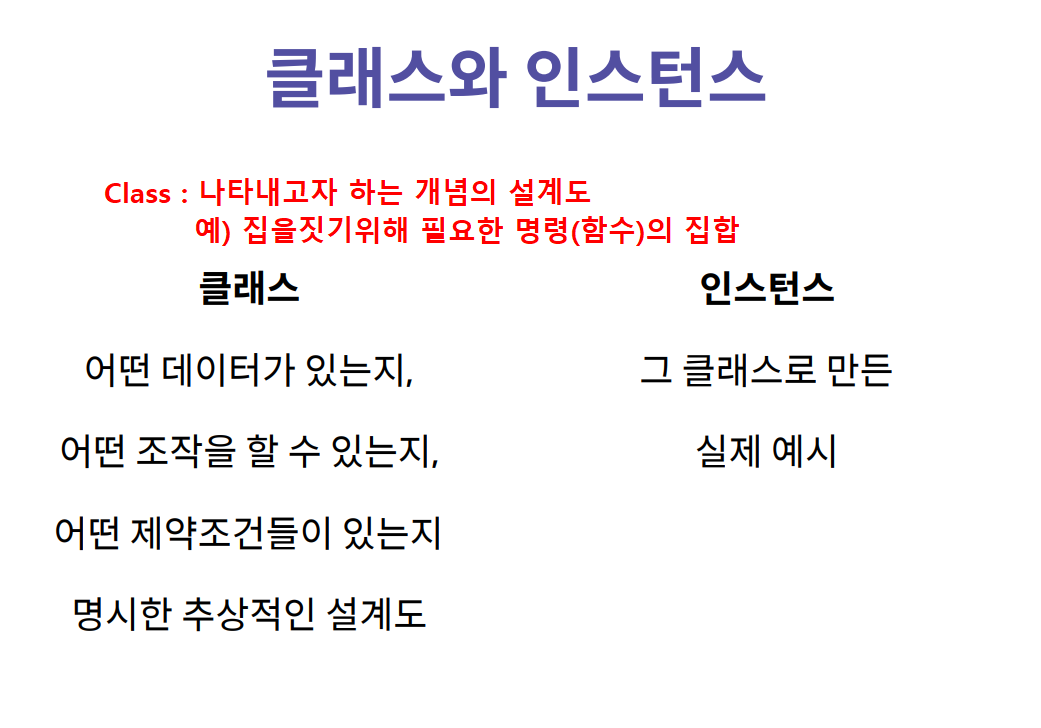

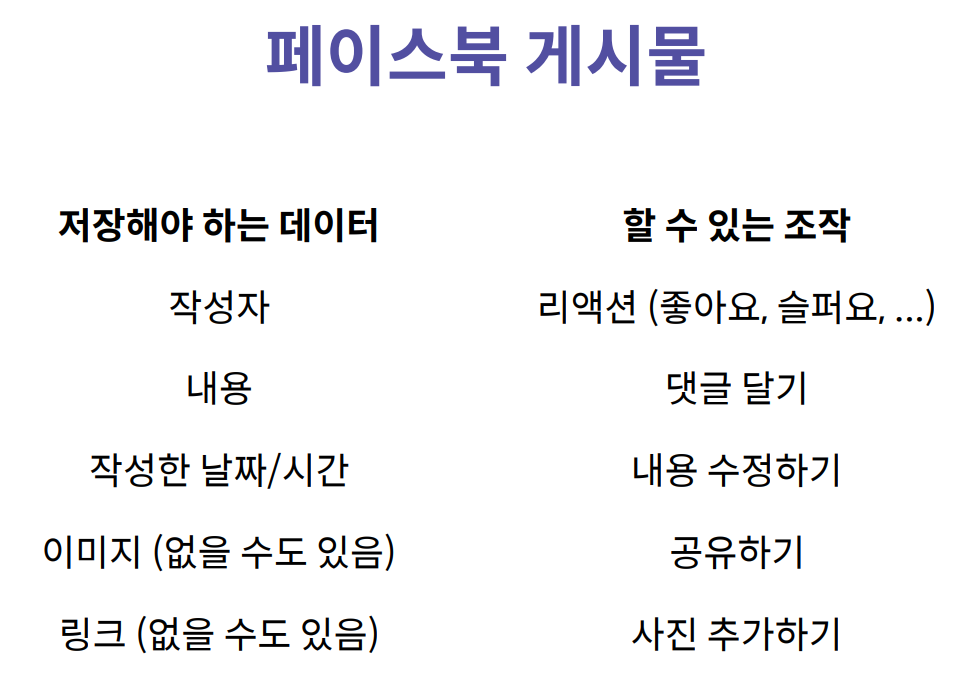

## 6.Network Class생성

In [15]:
class RBM():
  def __init__(self, nv, nh): # Class는 init으로만 작동 (nv = 가시노드숫자,nh = 은닉노드숫자)
    self.W = torch.randn(nh, nv) # 은닉/가시노드 무게초기값 설정 (정규분포)
    self.a = torch.randn(1, nh) # 은닉노드(nh) 편향확률(p) 설정
    self.b = torch.randn(1, nv) # 가시노드(nh) 무계확률(p) 설정

  def sample_h(self, x): # sample(x)에 대한 판별값 return함수
    wx = torch.mm(x, self.W.t()) # 사전 설정됨 무계초기값(가중치)을 역치행렬로 구성
    activation = wx + self.a.expand_as(wx) # 가중치와 편항으로 activation설정
    p_h_given_v = torch.sigmoid(activation) # activation값으로 sigmoid판별
    return p_h_given_v, torch.bernoulli(p_h_given_v) #sigmoid판별값, 베르누이반환값 return

  def sample_v(self, y): # sample(y)에 대한 판별값 return함수
    wy = torch.mm(y, self.W)
    activation = wy + self.b.expand_as(wy)
    p_v_given_h = torch.sigmoid(activation)
    return p_v_given_h, torch.bernoulli(p_v_given_h)

  def train(self, v0, vk, ph0, phk): #무계초기값 (가중치), 편향 update
    self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t() #은닉노드k번수행값 update(hk)
    self.a += torch.sum((ph0 - phk), 0) #은닉노드 update
    self.b += torch.sum((v0 - vk), 0) #가시노드 update

nv = len(training_set[0]) # 영화수 (nv,가시노드)
nh = 100 # 변수개수 (nh,장르,배우등등...일반적으로 nv보다는 적게)
batch_size = 100 #학습시킬 size(관측치)
rbm = RBM(nv, nh) # Class 실행 (nv,nh global 전역변수설정)

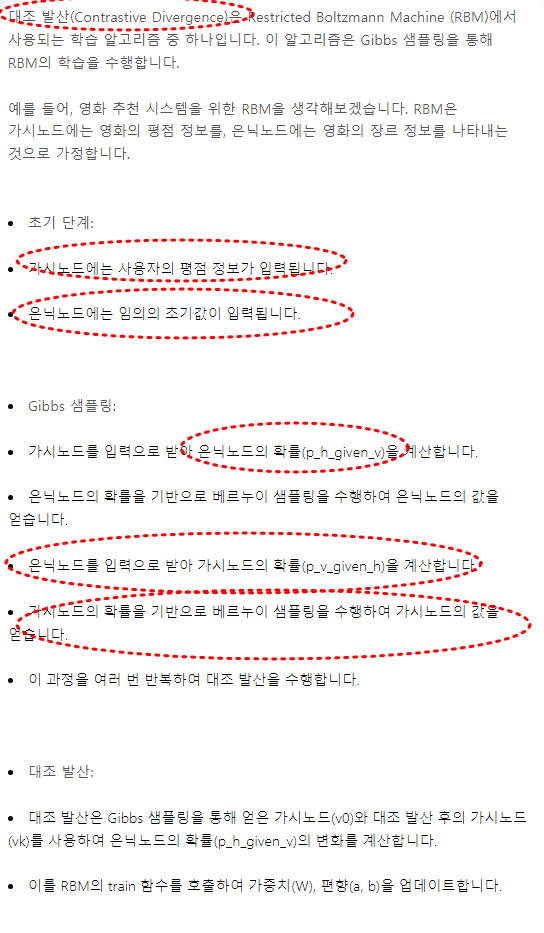

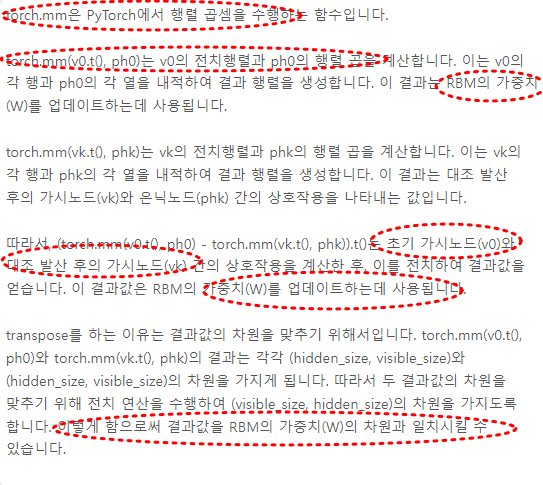

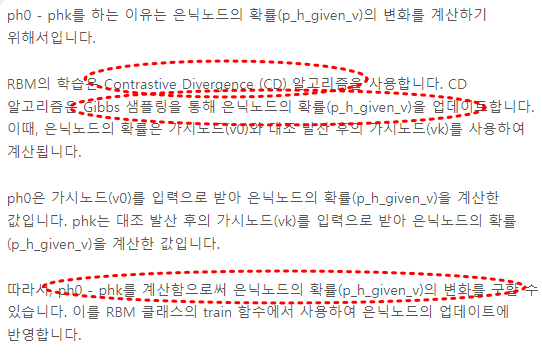

In [16]:
a = 1.2
b = 2.3
sum((a,b),1) #sum은 literation형태만 가능

4.5

## 7.Training


In [17]:
training_set

tensor([[-1.,  1.,  1.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1.,  1., -1.,  ..., -1., -1., -1.]])

In [18]:
for i in range(0,843,100):
    print(i)

0
100
200
300
400
500
600
700
800


In [19]:
nb_epoch = 10 # 943명 정보 10번 반복
for epoch in range(1, nb_epoch + 1): #epochs는 1~ 10
  train_loss = 0 #최초 loss 0부터 시작
  s = 0. # epochs횟수로 누적평균값구하기 위함 (예) 10/1, 30/2,....)
  for id_user in range(0, nb_users - batch_size, batch_size): #마지막 batch : 843 ~ 943 (100개 batch씩 학습)
    vk = training_set[id_user : id_user + batch_size] # k차 (batch size = 100)
    v0 = training_set[id_user : id_user + batch_size] # 최초
    ph0,_ = rbm.sample_h(v0) # rmb class내 sample_h 함수의 첫번째값으로 반환 (hidden확률)
    for k in range(10): #대조발산 진행 (최적값) 10번수행
      _,hk = rbm.sample_h(vk) # hk = 가시노드를 넣어서 나온 베르누이값
      _,vk = rbm.sample_v(hk) # vk = vk를 다시 hk를 넣어서 나온 베르누이값 (대조발산)
      vk[v0<0] = v0[v0<0] # v0 원래값이 -1 (평가하지 않은 경우에는 -1로 값을 유지하도록함)
    phk,_ = rbm.sample_h(vk) # phk = 가시노드를 넣어서 나온 10번째 확률 값
    rbm.train(v0, vk, ph0, phk)
    train_loss += torch.mean(torch.abs(v0[v0 >= 0] - vk[v0 >= 0])) # 관측된 값(-1이아님)으로만 차이를 평균
    s += 1. # 9번 배치돔
  print('epoch: '+str(epoch)+' loss: '+str(train_loss/s)) # 각 batch에서 나온 결과를 평균으로 계산


epoch: 1 loss: tensor(0.3596)
epoch: 2 loss: tensor(0.2450)
epoch: 3 loss: tensor(0.2527)
epoch: 4 loss: tensor(0.2498)
epoch: 5 loss: tensor(0.2449)
epoch: 6 loss: tensor(0.2481)
epoch: 7 loss: tensor(0.2465)
epoch: 8 loss: tensor(0.2466)
epoch: 9 loss: tensor(0.2473)
epoch: 10 loss: tensor(0.2476)


## 8.Test (MAE)


In [20]:
nb_users

943

In [21]:
test_loss = 0
s = 0.
for id_user in range(nb_users): #epochs,batch size는 training시에만 활용함
    v = training_set[id_user:id_user+1] #training set으로 RBM을 활성화해야함 (입력값)
    vt = test_set[id_user:id_user+1] #test_set으로작업 (배열로 표기하기 위해 test_set[1:2]로 표기)
    if len(vt[vt>=0]) > 0:
        _,h = rbm.sample_h(v)
        _,v = rbm.sample_v(h)
        test_loss += torch.mean(torch.abs(vt[vt>=0] - v[vt>=0])) #배열상 -1은제외
        s += 1.
print('test loss: '+str(test_loss/s))

test loss: tensor(0.2486)


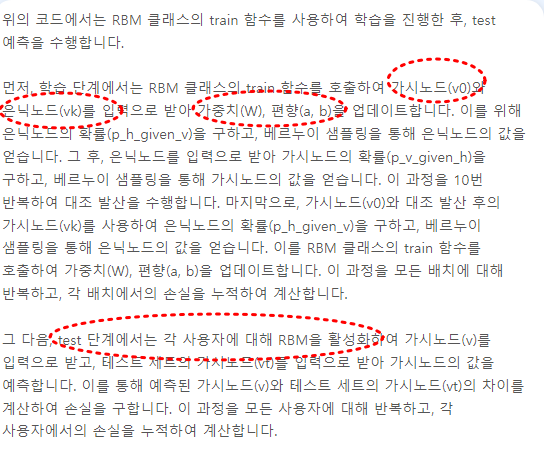

## 9.Train/Test (RMSE)

In [22]:
nb_epoch = 10
for epoch in range(1, nb_epoch + 1): # epchs 10번 반복
    train_loss = 0 # train loss는 0으로부터 시작
    s = 0. # train loss의 누적 평균 계산을 위해
    for id_user in range(0, nb_users - batch_size, batch_size): # 0,100, 200,.... 800
        vk = training_set[id_user:id_user+batch_size] # training data 100개 batch 9개 생성 (변경가시노드)
        v0 = training_set[id_user:id_user+batch_size] # training data 100개 batch 9개 생성 (최초가시노드)
        ph0,_ = rbm.sample_h(v0) #가시노드 입력을 통해 은닉노드 확률 산출
        for k in range(10): #10번의 대조 발산 (은닉노드로 가시노드 만들기)
            _,hk = rbm.sample_h(vk) # 최신 가시노드로 은닉대조 대조발산값 생성 (베르누이)
            _,vk = rbm.sample_v(hk) # 최신 은닉노드 발산값으로 가시노드 대조발산 (베르누이)
            vk[v0<0] = v0[v0<0] # 가시노드가 -1인값에 대해서는 변경하지 않음 (-1유지)
        phk,_ = rbm.sample_h(vk) # 대조발산가시노드값으로 은닉노드확률 값 산출
        rbm.train(v0, vk, ph0, phk) #최초가시노드, 대조발산 가시노드, 최초 은닉노드확률, 대조발산은닉노드확률
        train_loss += np.sqrt(torch.mean((v0[v0>=0] - vk[v0>=0])**2)) # RMSE(np.sqrt : root mean,square,error)
        s += 1.
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))

test_loss = 0
s = 0.
for id_user in range(nb_users):
    v = training_set[id_user:id_user+1]
    vt = test_set[id_user:id_user+1]
    if len(vt[vt>=0]) > 0:
        _,h = rbm.sample_h(v)
        _,v = rbm.sample_v(h)
        test_loss += np.sqrt(torch.mean((vt[vt>=0] - v[vt>=0])**2)) # RMSE here
        s += 1.
print('test loss: '+str(test_loss/s))

epoch: 1 loss: tensor(0.4981)
epoch: 2 loss: tensor(0.4998)
epoch: 3 loss: tensor(0.4967)
epoch: 4 loss: tensor(0.4969)
epoch: 5 loss: tensor(0.4957)
epoch: 6 loss: tensor(0.4974)
epoch: 7 loss: tensor(0.4934)
epoch: 8 loss: tensor(0.4974)
epoch: 9 loss: tensor(0.4973)
epoch: 10 loss: tensor(0.4985)
test loss: tensor(0.4546)


 - [RMSE]
  - 예측값과 실제값 간의 차이를 제곱하여 평균한 뒤, 다시 제곱근을 취한 값입니다. 이는 오차의 크기를 나타내는 지표로, 예측값과 실제값 간의 차이가 클수록 오차의 크기도 커집니다. RMSE는 이러한 오차의 크기를 반영하기 때문에 이상치(outlier)에 민감하게 반응할 수 있습니다.

 - [MAE]
  - 예측값과 실제값 간의 차이의 절댓값을 평균한 값입니다. MAE는 오차의 크기를 절댓값으로만 고려하며, 이상치에 덜 민감합니다. 따라서, RMSE보다 이상치에 영향을 덜 받는다고 볼 수 있습니다.

  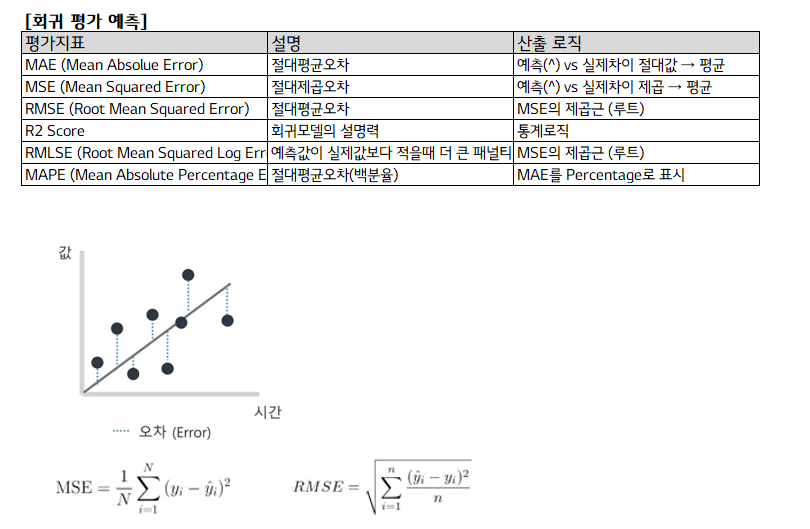